# Data Description

This data is for the purpose of bias correction of next-day maximum and minimum air temperatures forecast of the LDAPS model operated by the Korea Meteorological Administration over Seoul, South Korea. 

This data consists of summer data from 2013 to 2017. The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables. 

There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. Hindcast validation was conducted for the period from 2015 to 2017.

# Import Required Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

In [10]:
#importing dataset from github

df=pd.read_csv('https://raw.githubusercontent.com/dsrscientist/Dataset2/main/temperature.csv')
df.head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,30-06-2013,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.0,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,30-06-2013,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,0.0,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,30-06-2013,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,0.257469,0.204091,0.142125,0.0,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,30-06-2013,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,0.226002,0.161157,0.134249,0.0,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,30-06-2013,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,0.249995,0.178892,0.170021,0.0,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


We have pulled the dataset from the github and will work on this dataset

In [6]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [5]:
df.dtypes

station             float64
Date                 object
Present_Tmax        float64
Present_Tmin        float64
LDAPS_RHmin         float64
LDAPS_RHmax         float64
LDAPS_Tmax_lapse    float64
LDAPS_Tmin_lapse    float64
LDAPS_WS            float64
LDAPS_LH            float64
LDAPS_CC1           float64
LDAPS_CC2           float64
LDAPS_CC3           float64
LDAPS_CC4           float64
LDAPS_PPT1          float64
LDAPS_PPT2          float64
LDAPS_PPT3          float64
LDAPS_PPT4          float64
lat                 float64
lon                 float64
DEM                 float64
Slope               float64
Solar radiation     float64
Next_Tmax           float64
Next_Tmin           float64
dtype: object

We have a 25 columns in the dataset which are in float & object type.

In [8]:
df.shape

(7752, 25)

We have a 7752 rows and 25 columns in the dataset.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  LDAPS_PPT3        7677 non-null   float64


Based on the above info - I can see the dataset have a null value in 20 columns. So, we will make a treatment in this data on upcoming step.

# Data Treatment

In [17]:
df["Day"] = pd.to_datetime(df.Date, format="%d-%m-%Y").dt.day
df["Month"] = pd.to_datetime(df["Date"], format = "%d-%m-%Y").dt.month
df.drop(["Date"],axis=1,inplace=True)

Date - convert object type into int type - I have splited into two columns because day & Month will help to perform the prediction accurately.

Also, I have dropped the "Data" column because we splitted into two columns each.

In [26]:
df.dropna(inplace=True)

I have dropped the null value because to make a prediction accurately. There is another option to fill the data through mean but that won't be much effective. Hence, I decided to drop.

In [30]:
df.shape

(7588, 26)

Now, We have a 7588 rows and 26 columns in the dataset.

In [42]:
#Re-arrange the data frame in the dataset for my convininence

df=df[['station','Present_Tmax','Present_Tmin','LDAPS_RHmin','LDAPS_RHmax','LDAPS_Tmax_lapse','LDAPS_Tmin_lapse','LDAPS_WS','LDAPS_LH','LDAPS_CC1','LDAPS_CC2','LDAPS_CC3','LDAPS_CC4','LDAPS_PPT1','LDAPS_PPT2','LDAPS_PPT3','LDAPS_PPT4','lat','lon','DEM','Slope','Solar radiation','Day','Month','Next_Tmax','Next_Tmin']]

# Data Checking

In [43]:
df.isnull().sum()

station             0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Day                 0
Month               0
Next_Tmax           0
Next_Tmin           0
dtype: int64

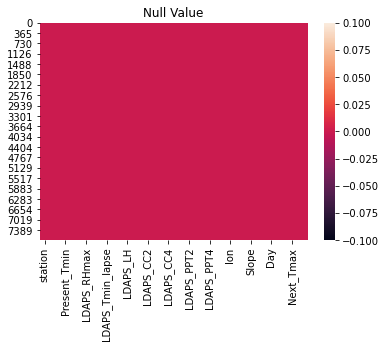

In [44]:
sns.heatmap(df.isnull())
plt.title("Null Value")
plt.show()

Just I ensure through visualization - We don't gave a null value in the dataset.

In [45]:
df.dtypes

station             float64
Present_Tmax        float64
Present_Tmin        float64
LDAPS_RHmin         float64
LDAPS_RHmax         float64
LDAPS_Tmax_lapse    float64
LDAPS_Tmin_lapse    float64
LDAPS_WS            float64
LDAPS_LH            float64
LDAPS_CC1           float64
LDAPS_CC2           float64
LDAPS_CC3           float64
LDAPS_CC4           float64
LDAPS_PPT1          float64
LDAPS_PPT2          float64
LDAPS_PPT3          float64
LDAPS_PPT4          float64
lat                 float64
lon                 float64
DEM                 float64
Slope               float64
Solar radiation     float64
Day                 float64
Month               float64
Next_Tmax           float64
Next_Tmin           float64
dtype: object

# Describe Dataset

In [46]:
#Statistical Summary
df.describe()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Day,Month,Next_Tmax,Next_Tmin
count,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.00000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000
mean,13.014101,29.748366,23.195809,56.724969,88.360823,29.620128,23.511786,7.094097,62.492606,0.368510,0.355528,0.317546,0.298268,0.589008,0.480738,0.275007,0.265373,37.544792,126.99142,61.918136,1.259755,5343.724208,15.939510,7.465999,30.241526,22.910820
std,7.217858,2.967401,2.400880,14.626559,7.199456,2.943496,2.342579,2.177034,33.686158,0.262260,0.257922,0.249833,0.253392,1.927577,1.743327,1.146087,1.179661,0.050428,0.07922,54.323529,1.372748,429.782561,8.906521,0.528635,3.111807,2.482256
min,1.000000,20.000000,11.300000,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.456200,126.82600,12.370000,0.098500,4329.520508,1.000000,6.000000,17.400000,11.300000
25%,7.000000,27.800000,21.600000,45.960243,84.203724,27.673756,22.086820,5.675358,37.206201,0.146546,0.140324,0.100950,0.081495,0.000000,0.000000,0.000000,0.000000,37.510200,126.93700,28.700000,0.271300,5001.485717,8.000000,7.000000,28.200000,21.300000
50%,13.000000,29.900000,23.400000,55.023199,89.784122,29.709537,23.758249,6.547838,56.898324,0.315706,0.311676,0.261795,0.227459,0.000000,0.000000,0.000000,0.000000,37.550700,126.99500,45.716000,0.618000,5441.987305,16.000000,7.000000,30.400000,23.100000
75%,19.000000,32.000000,24.800000,67.115099,93.742725,31.711109,25.155660,8.028960,84.235666,0.574174,0.557164,0.496444,0.498127,0.052594,0.017735,0.007855,0.000017,37.577600,127.04200,59.832400,1.767800,5729.485840,24.000000,8.000000,32.600000,24.600000
max,25.000000,37.600000,29.900000,98.524734,100.000153,38.542255,29.619342,21.857621,213.414006,0.967277,0.968353,0.983789,0.974710,23.701544,21.621661,15.841235,16.655469,37.645000,127.13500,212.335000,5.178200,5992.895996,31.000000,8.000000,38.900000,29.800000


We have a outlier and skewness in the columns in the dataset. So we will check in further step

# Correlation

In [47]:
df.corr()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Day,Month,Next_Tmax,Next_Tmin
station,1.000000,0.113301,0.133282,-0.067846,-0.169351,0.069856,0.105277,0.005822,-0.132129,0.006539,0.003526,-0.000161,0.005005,-0.001954,-0.007635,-0.013865,-0.011085,-0.239118,-0.118845,-0.256706,-0.091721,-0.021194,-0.000799,0.003114,0.107747,0.128184
Present_Tmax,0.113301,1.000000,0.615208,-0.209059,-0.306943,0.573777,0.628705,-0.125952,0.134246,-0.316333,-0.216976,-0.146391,-0.143069,-0.114917,-0.104779,-0.127248,-0.107295,-0.054134,0.007695,-0.189439,-0.107079,-0.022114,-0.151982,0.147358,0.610357,0.621048
Present_Tmin,0.133282,0.615208,1.000000,0.122200,-0.018576,0.467904,0.772061,-0.038779,-0.012817,0.084348,0.090038,-0.004719,-0.046694,0.111577,0.066207,-0.052428,-0.070391,-0.081417,-0.045174,-0.254084,-0.148423,0.059765,-0.114294,0.084047,0.463523,0.796975
LDAPS_RHmin,-0.067846,-0.209059,0.122200,1.000000,0.578358,-0.569580,0.085237,0.289422,-0.072195,0.612831,0.744774,0.688069,0.513937,0.259039,0.389572,0.237512,0.167311,0.085027,-0.077590,0.100684,0.122454,0.242168,-0.060702,-0.190674,-0.446824,0.093249
LDAPS_RHmax,-0.169351,-0.306943,-0.018576,0.578358,1.000000,-0.377293,-0.118965,0.131269,0.238986,0.435937,0.390620,0.224734,0.127242,0.268019,0.227581,0.132436,0.118101,0.194820,0.025563,0.176557,0.219436,0.146622,-0.014242,-0.117317,-0.289788,-0.076415
LDAPS_Tmax_lapse,0.069856,0.573777,0.467904,-0.569580,-0.377293,1.000000,0.653425,-0.316011,0.043663,-0.440878,-0.525380,-0.542728,-0.429739,-0.115659,-0.248369,-0.193749,-0.170415,-0.044052,0.091568,-0.181433,-0.163891,0.047414,-0.160191,0.096915,0.835729,0.589963
LDAPS_Tmin_lapse,0.105277,0.628705,0.772061,0.085237,-0.118965,0.653425,1.000000,-0.134652,-0.139675,0.008714,0.046537,-0.044998,-0.079536,0.034956,-0.002743,-0.093116,-0.103541,-0.099452,-0.024703,-0.198396,-0.187864,0.157763,-0.171284,0.023412,0.592119,0.886513
LDAPS_WS,0.005822,-0.125952,-0.038779,0.289422,0.131269,-0.316011,-0.134652,1.000000,0.004427,0.285349,0.257226,0.238155,0.218870,0.141503,0.181634,0.147199,0.134428,0.033025,-0.063009,0.188540,0.169223,0.120630,-0.040088,-0.113617,-0.351107,-0.102021
LDAPS_LH,-0.132129,0.134246,-0.012817,-0.072195,0.238986,0.043663,-0.139675,0.004427,1.000000,-0.148314,-0.265382,-0.246709,-0.173156,-0.018708,-0.084375,0.009495,0.012372,0.133309,0.024476,0.056362,0.087517,-0.044956,-0.019588,0.060947,0.156779,-0.060392
LDAPS_CC1,0.006539,-0.316333,0.084348,0.612831,0.435937,-0.440878,0.008714,0.285349,-0.148314,1.000000,0.779510,0.516698,0.362670,0.446930,0.389368,0.166763,0.088897,-0.010268,-0.007962,-0.017378,-0.023893,0.218285,-0.024234,-0.212477,-0.459705,-0.012877


We got the correlation result from the dataset. But It is difficult to understand the result Hence we are visualization this result through heatmap.

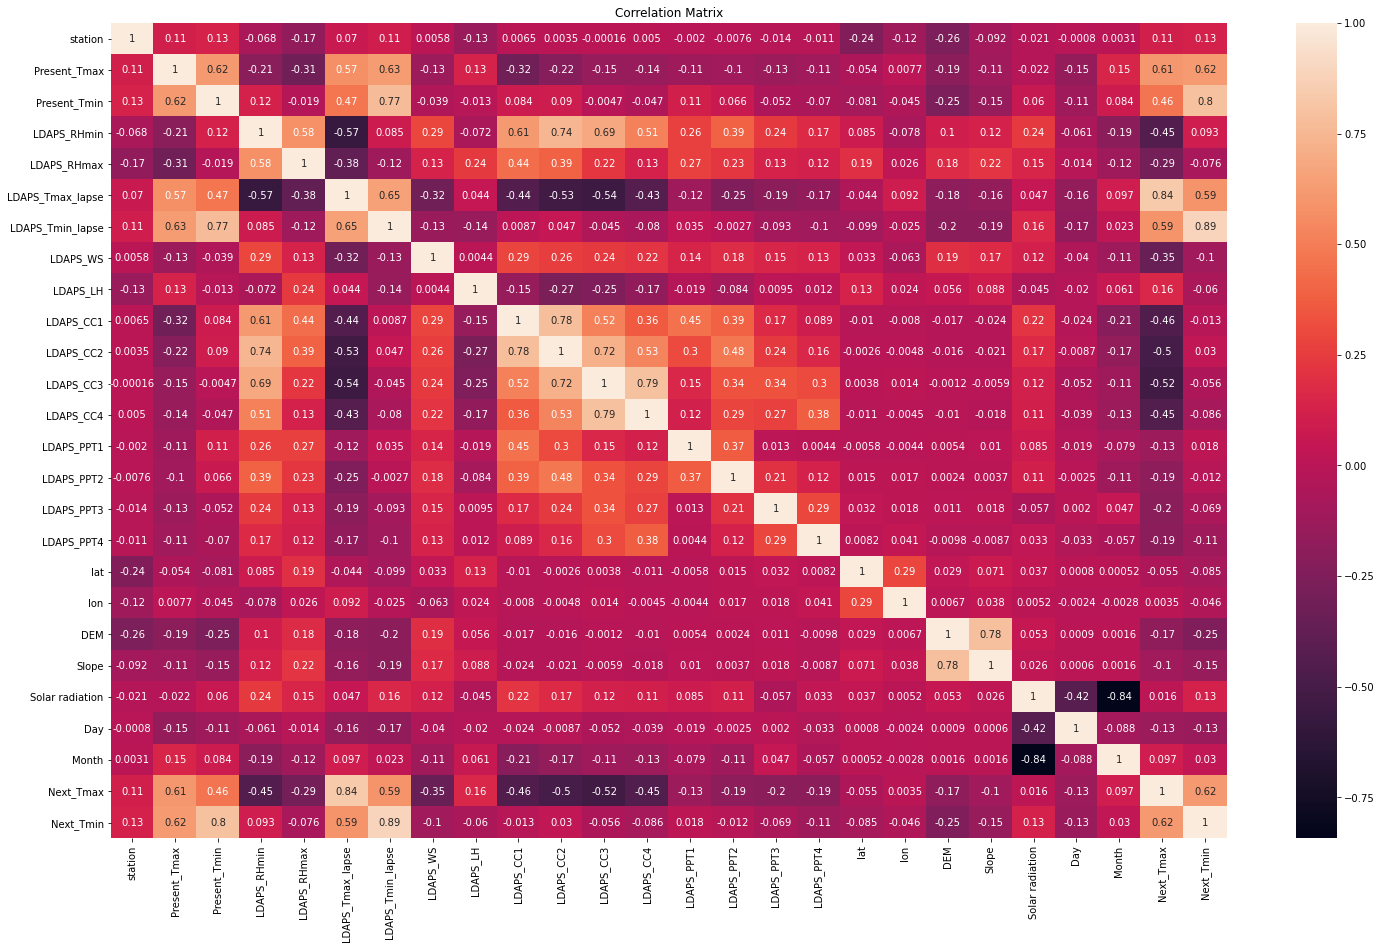

In [48]:
corr_mat=df.corr()
plt.figure(figsize=[25,15])
sns.heatmap(corr_mat,annot=True)
plt.title("Correlation Matrix")
plt.show()

# Outcome of Correlation

We can see the positive and negative correlation with the target column.

Also,We can strong correlation with Present Tmax with 62% and LDAPS with 89%.

# Outlier Checking 

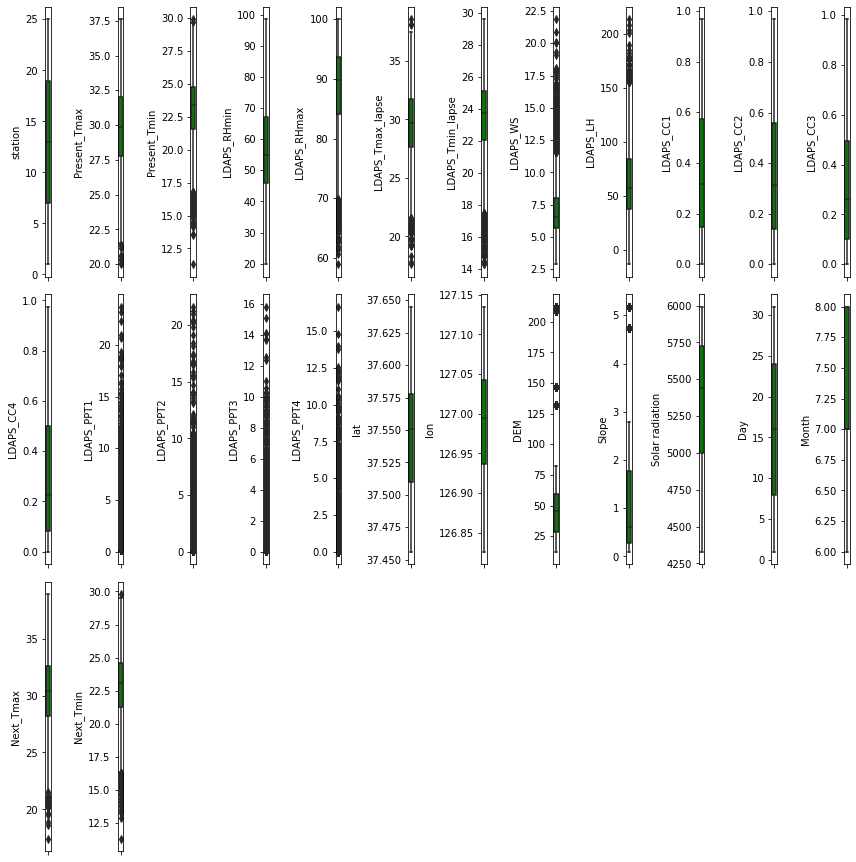

In [50]:
collist=df.columns.values
ncol=12
nrow=6
plt.figure(figsize=(ncol,2*ncol))
for i in range (0,len(collist)):
    plt.subplot(nrow,ncol,i+1)
    sns.boxplot(df[collist[i]],color='green',orient='v')
    plt.tight_layout()

In the above - we have a outlier in most of the columns around 15 columns

# Checking Skewness

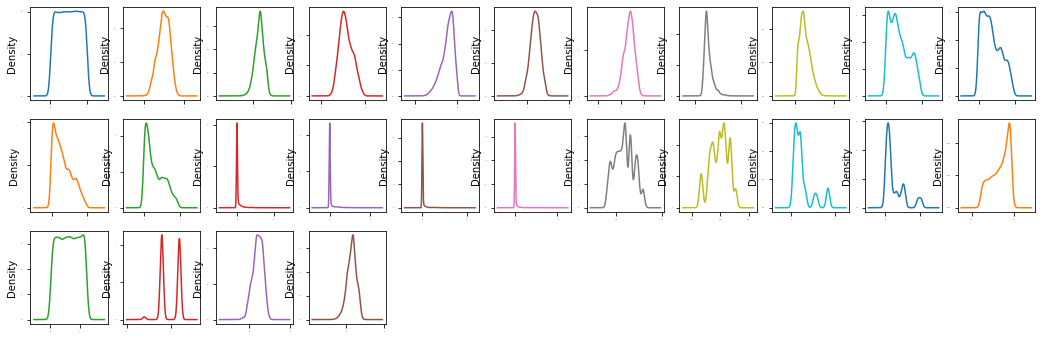

In [51]:
df.plot(kind='density',subplots=True,layout=(6,11),sharex=False,legend=False,fontsize=1,figsize=(18,12))
plt.show()

In [52]:
df.skew()

station            -0.004178
Present_Tmax       -0.257069
Present_Tmin       -0.353822
LDAPS_RHmin         0.301396
LDAPS_RHmax        -0.845264
LDAPS_Tmax_lapse   -0.222349
LDAPS_Tmin_lapse   -0.574035
LDAPS_WS            1.553926
LDAPS_LH            0.662971
LDAPS_CC1           0.456716
LDAPS_CC2           0.473929
LDAPS_CC3           0.639649
LDAPS_CC4           0.663815
LDAPS_PPT1          5.305906
LDAPS_PPT2          5.710360
LDAPS_PPT3          6.356670
LDAPS_PPT4          6.681256
lat                 0.085377
lon                -0.289048
DEM                 1.721617
Slope               1.559050
Solar radiation    -0.524325
Day                -0.010718
Month              -0.174856
Next_Tmax          -0.334842
Next_Tmin          -0.393662
dtype: float64

From the above info - we can see the skewness in the dataset. So, We will rectify this in upcoming step.

Also, We can consider the -/+.5 is standard

# Data Cleaning

# Removing Outlier

In [53]:
from scipy.stats import zscore
z=np.abs(zscore(df))
print(z.shape)
threshold=3
print(np.where(z>3))

(7588, 26)
(array([  25,   25,   26, ..., 7581, 7582, 7582], dtype=int64), array([ 7, 14, 14, ...,  2,  2,  6], dtype=int64))


In [54]:
df_new=df[(z<3).all(axis=1)]
print(df.shape)
print(df_new.shape)

(7588, 26)
(6739, 26)


We have applied ZSCORE technic for removing outlier in the dataset.

In [55]:
Loss_percentage=(7588-6739)/7588*100
print(Loss_percentage)

11.188719030047443


After removing the outlier - we have only 11% dataloss. Now,it is good to go with this data.

# Creating Feature and Test column for model

In [56]:
X=df_new.iloc[:,:-2]
Y=df_new.iloc[:,-2]

I have created the feature and target columns. It will help me to do trian & test for preparing model

In [57]:
X.columns

Index(['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
       'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
       'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1',
       'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope',
       'Solar radiation', 'Day', 'Month'],
      dtype='object')

# Data Transform for Remove Skewness

In [58]:
from sklearn.preprocessing import power_transform
DF=power_transform(X,method='yeo-johnson')
DF=pd.DataFrame(DF,columns=X.columns)

We have removed the skewness from the dadaset. Let use this for model preparation.

# Finding the best model and Random State

In [60]:
from sklearn.preprocessing import StandardScaler
SC=StandardScaler()
x=SC.fit_transform(DF)

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
maxAccu=0
maxRS=0
for i in range (0,100):
    x_train,x_test,Y_train,Y_test = train_test_split(x,Y,test_size=.30,random_state=i)
    LR =LinearRegression()
    LR.fit(x_train,Y_train)
    PX1=LR.predict(x_train)
    PY1=LR.predict(x_test)
    R2 = r2_score(Y_test, PY1)
    if R2>maxAccu:
        maxAccu=R2
        maxRS=i
print("Best Accuracy is",maxAccu*100,"on Random state",maxRS)

Best Accuracy is 78.5669702140241 on Random state 43


In [62]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
maxAccu=0
maxRS=0
for i in range (0,100):
    x_train,x_test,Y_train,Y_test = train_test_split(x,Y,test_size=.30,random_state=i)
    LA =Lasso()
    LA.fit(x_train,Y_train)
    PX2=LA.predict(x_train)
    PY2=LA.predict(x_test)
    R2 = r2_score(Y_test, PY2)
    if R2>maxAccu:
        maxAccu=R2
        maxRS=i
print("Best Accuracy is",maxAccu*100,"on Random state",maxRS)

Best Accuracy is 56.65132124002682 on Random state 43


In [63]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
maxAccu=0
maxRS=0
for i in range (0,100):
    x_train,x_test,Y_train,Y_test = train_test_split(x,Y,test_size=.30,random_state=i)
    RR =Ridge()
    RR.fit(x_train,Y_train)
    PX3=RR.predict(x_train)
    PY3=RR.predict(x_test)
    R2 = r2_score(Y_test,PY3)
    if R2>maxAccu:
        maxAccu=R2
        maxRS=i
print("Best Accuracy is",maxAccu*100,"on Random state",maxRS)

Best Accuracy is 78.57931952293595 on Random state 43


In [64]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score

maxAccu=0
maxRS=0
for i in range (0,100):
    x_train,x_test,Y_train,Y_test = train_test_split(x,Y,test_size=.30,random_state=i)
    EL =ElasticNet()
    EL.fit(x_train,Y_train)
    PX4=EL.predict(x_train)
    PY4=EL.predict(x_test)
    R2 = r2_score(Y_test,PY4)
    if R2>maxAccu:
        maxAccu=R2
        maxRS=i
print("Best Accuracy is",maxAccu*100,"on Random state",maxRS)

Best Accuracy is 63.34168287892668 on Random state 43


Best Accuracy score got from the model which are below i have listed:

1) LinearRegression score is - 79%  
2) Lasso score is - 57%  
3) Ridge score is - 79%  
4) ElasticNet score is - 63%

Based on the above score - 2 models have a same score However, we will check with cross validation score then finalize the model.

# Creating the Train_Test_Split

In [65]:
x_train,x_test,Y_train,Y_test = train_test_split(x,Y,test_size=.30,random_state=43)

# Cross-Validation of the Model

In [71]:
from sklearn.model_selection import cross_val_score
cv1_score=cross_val_score(LR,x,Y,cv=3)
cv2_score=cross_val_score(LA,x,Y,cv=3)
cv3_score=cross_val_score(RR,x,Y,cv=3)
cv4_score=cross_val_score(EL,x,Y,cv=3)
cv1_mean=cv1_score.mean()
cv2_mean=cv2_score.mean()
cv3_mean=cv3_score.mean()
cv4_mean=cv4_score.mean()
print(f"Cross Validation Score of is :",cv1_mean*100)
print(f"Cross Validation Score of is :",cv2_mean*100)
print(f"Cross Validation Score of is :",cv3_mean*100)
print(f"Cross Validation Score of is :",cv4_mean*100)

Cross Validation Score of is : 71.98319131108363
Cross Validation Score of is : 50.06602282790775
Cross Validation Score of is : 72.00098556493116
Cross Validation Score of is : 56.20193507664503


We have a cross validation score which will help us to choose the model.

I have choosed the LinearRegression model because it have 7% minimum difference with cross validation score. Also, all the score have a same difference

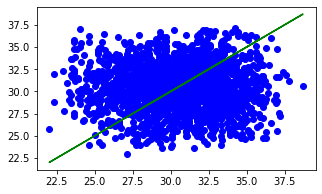

In [75]:
plt.figure(figsize=(5,3))
plt.scatter(x=Y_test,y=PY1,color='b')
plt.plot(Y_test,Y_test,color='g')
plt.show()

# Regularization

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
parameters = {'alpha':[.0001, .001, .01, .1, 1, 10, 100],'random_state':list(range(0,100))}
clf=GridSearchCV(RR,parameters)
clf.fit(x_train,Y_train)
print(clf.best_params_)

{'alpha': 0.01, 'random_state': 0}


In [78]:
RR=Ridge(alpha=.01,random_state=0)
RR.fit(x_train,Y_train)
RR.score(x_train,Y_train)
predict=RR.predict(x_test)
LR=r2_score(Y_test,predict)
print("Linear Score :",LR*100)

cv_score=cross_val_score(RR,x,Y,cv=3)
cv_mean=cv_score.mean()
print("CV Score :",cv_mean*100)

Linear Score : 78.56711281469002
CV Score : 71.98339921008358


# Ensemblie Technique

In [79]:
from sklearn.ensemble import RandomForestRegressor
parameters={'criterion':['mse','mae'],'max_features':["auto","sqrt","log2"]}
RF=RandomForestRegressor()
clf=GridSearchCV(RF,parameters)
clf.fit(x_train,Y_train)
print(clf.best_params_)

{'criterion': 'mse', 'max_features': 'log2'}


In [81]:
RF=RandomForestRegressor(criterion="mse",max_features="log2")
RF.fit(x_train,Y_train)
RF.score(x_train,Y_train)
pred=RF.predict(x_test)
RFS=r2_score(Y_test,pred)
print("R2 Score :",RFS*100)

rfs=cross_val_score(RF,x,Y,cv=5)
rfc=rfs.mean()
print("CV Score :",rfc*100)

R2 Score : 90.68149528899066
CV Score : 66.52611135517859


# Model Saving

In [82]:
import pickle
filename='Temperature_Project.pkl'
pickle.dump(RF,open(filename,'wb'))

# Conclusion

In [83]:
Loaded_load = pickle.load(open('Temperature_Project.pkl','rb'))
Result=Loaded_load.score(x_test,Y_test)
print(Result)

0.9068149528899065


In [84]:
Conclusion=pd.DataFrame([Loaded_load.predict(x_test)[:],predict[:]],index=["Predicted","Original"])
Conclusion

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

Output from the model - The Prediction is seems like very accurate. So the model is performing very well